In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
import time
#Lets import the dataset
df = pd.read_csv('final_df_norm.csv')
# print(df.head())

def make_unix(dt_object):
    #converts to epoch time with either a string or date time input
    
    if type(dt_object) is not datetime and type(dt_object) is not str:
        raise ValueError("input needs to be a datetime")
    elif type(dt_object) is str:
        
        timestrs = ['%d/%m/%Y %H:%M', '%Y/%m/%d %H:%M:%S', '%Y-%m']
        for timestr in timestrs:
            try:
                dt_object = datetime.strptime(dt_object,timestr)
                break
            except ValueError:
                continue
        
        #if the input to the function is a string convert to datetime 
        #and add in brisbane timezone to make a graceful conversion to unix time
        localtz = timezone('Australia/Brisbane')
        dt_object = localtz.localize(dt_object)

    return time.mktime(dt_object.timetuple())

#Change the date to unix time for easier comparison 

df['Date'] = df['Date'].apply(make_unix)
# print(df.head())

#Lets filter the df into a prediction set and excluded set if any columns malformed.
#And training/testing set (80-20% split)

#NOTE THE PRESENCE OF A a missing value inside the dataset at 2/10/2017 12:00. 
#This appears to be the only unintentionally blank value however.


df_pred = df[( pd.isna(df['Price'])==True) & (df['Date']>=make_unix('1/12/2017 0:00'))]

df_exclude = df[( pd.isna(df['Price'])==True) & (df['Date']<make_unix('1/12/2017 0:00'))]

print(df_pred.head())
print(df_exclude.head())

#Verify there are no missing values in the other columns
print('-----------------')
print('VERIFYING NO OTHER MISSING VALUES')

print(df[( pd.isna(df['Demand'])==True)])
print(df[( pd.isna(df['QNI Interconnector'])==True)])
print(df[( pd.isna(df['Date'])==True)])
#No other missing values so we are golden

#Now get the data set to sample for training/testing
#All non-empty values of Price
print('-----------------')
print('SAMPLE THE TRAINING SET')
df_samp = df[pd.isna(df['Price'])==False]

#Note the random_state to get reproducable results
df_train = df_samp.sample(random_state=1, frac=0.9)
df_test = df_samp.sample(random_state=1, frac=0.1)

print('Length of samp is {}. And train is {}, while test is {}'.format(len(df_samp),len(df_train),len(df_test)))

#Check the breakup of the dataset
assert len(df_train)+len(df_test) == len(df_samp)
assert len(df_exclude) + len(df_pred) + len(df_train)+len(df_test) == len(df)

#No errors. Fantastic

               Date    Demand  QNI Interconnector  Month  Hour  Gas Price  \
16031  1.512050e+09 -0.490003            0.682257     12   0.0  -0.545455   
16032  1.512052e+09 -0.575147            0.701121     12   0.5  -0.545455   
16033  1.512054e+09 -0.636802            0.763463     12   1.0  -0.545455   
16034  1.512056e+09 -0.675603            0.692472     12   1.5  -0.545455   
16035  1.512058e+09 -0.708237            0.756767     12   2.0  -0.545455   

       QLD 2016 monthly avg spot  NSW 2016 monthly avg spot  Daily Max Demand  \
16031                  -0.435482                  -0.567935         -0.232776   
16032                  -0.435482                  -0.567935         -0.232776   
16033                  -0.435482                  -0.567935         -0.232776   
16034                  -0.435482                  -0.567935         -0.232776   
16035                  -0.435482                  -0.567935         -0.232776   

       Monthly Average Demand  Price  
16031      

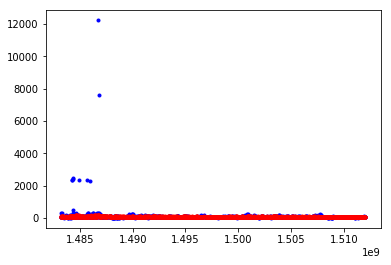

0.02515662571433719


['svm_no_external2018-08-06_06-35.pkl']

In [84]:
#Manually train a classifier with parameters C=c_val and gamma = g_val
from sklearn import svm, grid_search

X = df_train.drop(['Date','Price'],axis=1)
y = df_train['Price']

X_test = df_test.drop(['Date','Price'],axis=1)
y_test = df_test['Price']

c_val = 10
g_val = 0.1

svm_no_external = svm.NuSVR(kernel='rbf',C=c_val,gamma=g_val)
svm_no_external.fit(X, y)

score = svm_no_external.score(X_test,y_test)
y_predict = svm_no_external.predict(X_test)

#Plot of the results to see how well the classification went

import matplotlib.pyplot as plt
plt.plot(df_test['Date'],y_test,'b.')
plt.plot(df_test['Date'],y_predict,'r.')
plt.show()
print(score)

from sklearn.externals import joblib
file_save_time = datetime.strftime(datetime.now(),'%Y-%m-%d_%H-%M')
joblib.dump(svm_no_external, 'models/svm_no_external{}.pkl'.format(file_save_time))

In [83]:
#Lets start a search to refine the hyperparameters

def svr_param_selection(X, y, nfolds):
    Cs =  [0.001, 0.01,0.1, 1, 10,100,1000]
    gammas = [0.001 ,0.01 ,0.1, 1,10,100]
    gammas = np.logspace(-0.8,0,13)
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_s = grid_search.GridSearchCV(svm.SVR(kernel='rbf'), param_grid, cv=nfolds)
    grid_s.fit(X, y)
    grid_s.best_params_
    return grid_s.best_params_

best_params = svr_param_selection(X, y, 3)
print(best_params)
#{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
#result of 5 order of magnitude tests and evaluation of linear and rbf kernels

KeyboardInterrupt: 

In [85]:
#GRAPH THE OUTPUT AND COMPARE TO THE REAL ANSWERS

df_verify = pd.read_csv('ANSWER_DATASET.csv')
df_verify['Date'] = df_verify['Date'].apply(make_unix)

X_verify = df_pred.drop(['Date','Price'],axis=1)
y_verify = pd.DataFrame(svm_no_external.predict(X_verify))

#Merge the predicted values into the verification dataset
df_verify['Predicted Price'] = y_verify.iloc[1:]

import matplotlib.pyplot as plt
# '2017/12/01 00:30:00'
# '%Y/%m/%d %H:%M:%S'
# '%d/%m/%Y %H:%M'

#lets plot 4 graphs, one for each week

count = 0
for df_quarter in np.array_split(df_verify,4):
    count += 1
    plt.plot(df_quarter['Date'],df_quarter['Ans_Price'],'r.')
    plt.plot(df_quarter['Date'],df_quarter['Predicted Price'],'b-')
    plt.title('Spot Price for Week {}, Dec 17 (C={},gamma={})'.format(count,round(c_val,2),round(g_val,2)) )
    plt.xlabel('Epoch Time')
    plt.ylabel('Spot Price ($/MWh)')
    plt.legend()
#     plt.show()
    plt.savefig('figures/3graph_verify_week{}.png'.format(count))
    plt.clf()

#Calculating the mean average error

MAE = (1/len(df_verify['Predicted Price']))*(abs(df_verify['Predicted Price'] - df_quarter['Ans_Price'])).sum()
print(MAE)
    

3.847656282958379


In [77]:
np.logspace(0.5, 1.2, 13)

array([ 3.16227766,  3.61687361,  4.1368204 ,  4.73151259,  5.41169527,
        6.18965819,  7.07945784,  8.09717142,  9.26118728, 10.59253725,
       12.11527659, 13.85691863, 15.84893192])

In [79]:
np.logspace(1.2, 1.9, 13)

array([15.84893192, 18.12730881, 20.73321573, 23.71373706, 27.12272579,
       31.02177665, 35.48133892, 40.58198942, 46.41588834, 53.08844442,
       60.72021957, 69.44910714, 79.43282347])